# Find how many floors Jaime moved on the elevator
In the coordinate systems in this document, upward is always positive, and $g = 9.81 m \cdot s^{-2}$.

In [1]:
import numpy
import toyplot
import matplotlib.pyplot as plt
%matplotlib inline

## Import the raw data
The raw data for time didn't include a unit, so in this document, the unit of time is assumed to be seconds, and the data is reasonable with the unit of seconds.
The data at the start and the end which are outliers are not discarded because doing so will make system error removal impossible, but the data does not affect the calculation much. The reason for those outliers might be because Jaime was manually moving the phone.

In [2]:
# Load the CSV files
up_lines = open("up.csv").readlines()
down_lines = open("down.csv").readlines()

# [0] points to the "time" column and [3] points to the "gFz" column
up_time = numpy.asarray([x.split(',')[0] for x in up_lines[1:]], dtype="float32")
up_gforce_z = numpy.asarray([x.split(',')[3] for x in up_lines[1:]], dtype="float32")
down_time = numpy.asarray([x.split(',')[0] for x in down_lines[1:]], dtype="float32")
down_gforce_z = numpy.asarray([x.split(',')[3] for x in down_lines[1:]], dtype="float32")

## Plot the raw data
### Going up

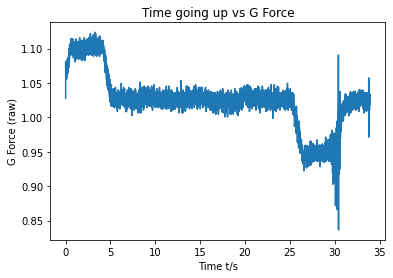

In [3]:
fig, ax = plt.subplots()
ax.set_title("Time going up vs G Force")
ax.set_xlabel("Time t/s")
ax.set_ylabel("G Force (raw)")
ax.plot(up_time, up_gforce_z);

### Going down

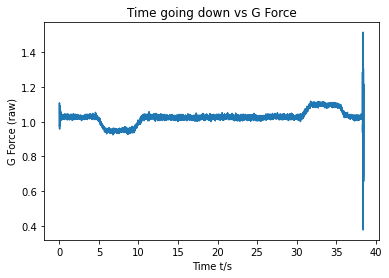

In [4]:
fig, ax = plt.subplots()
ax.set_title("Time going down vs G Force")
ax.set_xlabel("Time t/s")
ax.set_ylabel("G Force (raw)")
ax.plot(down_time, down_gforce_z);

 To make use of this data, the following calculation on the g-force is done:
 $$
 \begin{align}
 g\_force &= \frac{F}{G}\\
 F &= g\_force \cdot G\\
 F_{total} &= F+G\\
 F_{total} &= -g\_force \cdot G + G\\
 F_{total} &= G \cdot (1 - g\_force)\\
 a_{effective} &= g \cdot (1 - g\_force)
 \end{align}
 $$

In [5]:
up_accl_z = -9.81 * (1 - up_gforce_z)
down_accl_z = -9.81 * (1 - down_gforce_z)

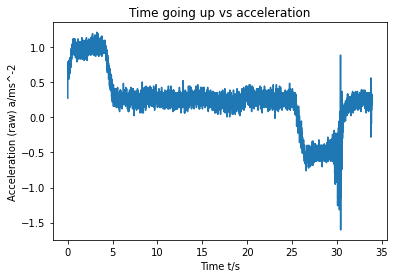

In [6]:
fig, ax = plt.subplots()
ax.set_title("Time going up vs acceleration")
ax.set_xlabel("Time t/s")
ax.set_ylabel("Acceleration (raw) a/ms^-2")
ax.plot(up_time, up_accl_z);

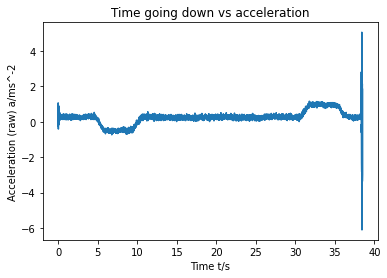

In [7]:
fig, ax = plt.subplots()
ax.set_title("Time going down vs acceleration")
ax.set_xlabel("Time t/s")
ax.set_ylabel("Acceleration (raw) a/ms^-2")
ax.plot(down_time, down_accl_z);

It is clear to see that when the elevator is moving with a constant speed, the G-Force sensor's reading is not $1$ as expected. It may be due to a systematic error.
To correct this possible error, the final velocity is calculated by accumulating the product of time and acceleration, or discreate intergration.
$$
v_f = \sum a\Delta t
$$
During the calculation process, two sets of velocity at a given time are calculated, the first set is the minimum value (named `*_velocity_z_under`):
$$
v_{t,min} =\sum_{i=0}^t a_i \cdot (t_i-t_{i-1})
$$
the second set is the maximum value (named `*_velocity_z_over`):
$$
v_{t,max} =\sum_{i=0}^t a_i \cdot (t_{i+1}-t_i)
$$

In [8]:
up_velocity_z_cumulative_under = 0
up_velocity_z_cumulative_over = 0
up_velocity_z_under = []
up_velocity_z_over = []

# Add one zero to pad the length of the velocity array
up_velocity_z_over.append(0)

for n, up_accl_here in enumerate(up_accl_z):
    if n + 1 != len(up_accl_z): # Under
        # No value for over-integration if this one is the last one
        under_timediff = up_time[n+1] - up_time[n]
        up_velocity_z_cumulative_under += under_timediff * up_accl_here
        up_velocity_z_under.append(up_velocity_z_cumulative_under)
    if n != 0: # Over
        # No value for under-integration if this one is the last one
        over_timediff = up_time[n] - up_time[n-1]
        up_velocity_z_cumulative_over += over_timediff * up_accl_here
        up_velocity_z_over.append(up_velocity_z_cumulative_over)
up_velocity_z_under.append(up_velocity_z_cumulative_under)

In [9]:
down_velocity_z_cumulative_under = 0
down_velocity_z_cumulative_over = 0
down_velocity_z_under = []
down_velocity_z_over = []

# Add one zero to pad the length of the velocity array
down_velocity_z_over.append(0)

for n, down_accl_here in enumerate(down_accl_z):
    if n + 1 != len(down_accl_z): # Under
        # No value for over-integration if this one is the last one
        under_timediff = down_time[n+1] - down_time[n]
        down_velocity_z_cumulative_under += under_timediff * down_accl_here
        down_velocity_z_under.append(down_velocity_z_cumulative_under)
    if n != 0: # Over
        # No value for under-integration if this one is the last one
        over_timediff = down_time[n] - down_time[n-1]
        down_velocity_z_cumulative_over += over_timediff * down_accl_here
        down_velocity_z_over.append(down_velocity_z_cumulative_over)
down_velocity_z_under.append(down_velocity_z_cumulative_under)

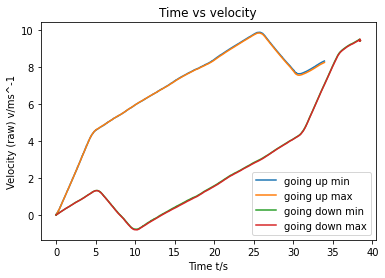

In [10]:
fig, ax = plt.subplots()
ax.set_title("Time vs velocity")
ax.set_xlabel("Time t/s")
ax.set_ylabel("Velocity (raw) v/ms^-1")
ax.plot(up_time, up_velocity_z_under, label="going up min")
ax.plot(up_time, up_velocity_z_over, label="going up max")
ax.plot(down_time, down_velocity_z_under, label="going down min")
ax.plot(down_time, down_velocity_z_over, label="going down max")
ax.legend(loc="lower right");

The final speed is expected to be $0$, because the elevator should have come to a final stop. But the real value is higher than that.  
The final speed for going up is

In [11]:
up_velocity_z_cumulative_under

8.336782198311539

Assuming the error is absolute and constant for each reading, this error is divided by the time, and distributed to each reading of g-force.

In [12]:
error_up_velocity_per_sec_under = up_velocity_z_cumulative_under/up_time[-1]
error_up_velocity_per_sec_over = up_velocity_z_cumulative_over/up_time[-1]
error_down_velocity_per_sec_under = down_velocity_z_cumulative_under/down_time[-1]
error_down_velocity_per_sec_over = down_velocity_z_cumulative_over/down_time[-1]
error_velocity_per_sec = numpy.mean([error_up_velocity_per_sec_under,
                                    error_up_velocity_per_sec_over, error_down_velocity_per_sec_under, error_down_velocity_per_sec_over])
up_velocity_z_cumulative_under = 0
up_velocity_z_cumulative_over = 0
up_velocity_z_under = []
up_velocity_z_over = []

# Add one zero to pad the length of the velocity array
up_velocity_z_over.append(0)

for n, up_accl_here in enumerate(up_accl_z):
    if n + 1 != len(up_accl_z): # Under
        # No value for over-integration if this one is the last one
        under_timediff = up_time[n+1] - up_time[n]
        up_velocity_z_cumulative_under += under_timediff * (up_accl_here - error_velocity_per_sec)
        up_velocity_z_under.append(up_velocity_z_cumulative_under)
    if n != 0: # Over
        # No value for under-integration if this one is the last one
        over_timediff = up_time[n] - up_time[n-1]
        up_velocity_z_cumulative_over += over_timediff * (up_accl_here - error_velocity_per_sec)
        up_velocity_z_over.append(up_velocity_z_cumulative_over)
up_velocity_z_under.append(up_velocity_z_cumulative_under)

down_velocity_z_cumulative_under = 0
down_velocity_z_cumulative_over = 0
down_velocity_z_under = []
down_velocity_z_over = []

# Add one zero to pad the length of the velocity array
down_velocity_z_over.append(0)

for n, down_accl_here in enumerate(down_accl_z):
    if n + 1 != len(down_accl_z): # Under
        # No value for over-integration if this one is the last one
        under_timediff = down_time[n+1] - down_time[n]
        down_velocity_z_cumulative_under += under_timediff * (down_accl_here - error_velocity_per_sec)
        down_velocity_z_under.append(down_velocity_z_cumulative_under)
    if n != 0: # Over
        # No value for under-integration if this one is the last one
        over_timediff = down_time[n] - down_time[n-1]
        down_velocity_z_cumulative_over += over_timediff * (down_accl_here - error_velocity_per_sec)
        down_velocity_z_over.append(down_velocity_z_cumulative_over)
down_velocity_z_under.append(down_velocity_z_cumulative_under)

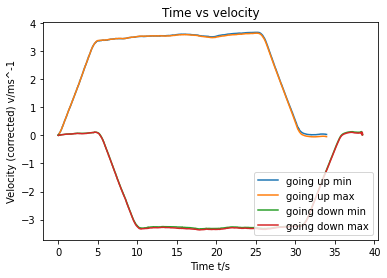

In [13]:
fig, ax = plt.subplots()
ax.set_title("Time vs velocity")
ax.set_xlabel("Time t/s")
ax.set_ylabel("Velocity (corrected) v/ms^-1")
ax.plot(up_time, up_velocity_z_under, label="going up min")
ax.plot(up_time, up_velocity_z_over, label="going up max")
ax.plot(down_time, down_velocity_z_under, label="going down min")
ax.plot(down_time, down_velocity_z_over, label="going down max")
ax.legend(loc="lower right");

Hence the displacement is calculated by performing a discreate integration on the corrected velocity.  
When going up:

In [14]:
up_displacement_z_cumulative_under = 0
up_displacement_z_cumulative_over = 0
up_displacement_z_under = []
up_displacement_z_over = []

# Add one zero to pad the length of the displacement array
up_displacement_z_over.append(0)

for n, up_velocity_here in enumerate(up_velocity_z_under):
    if n + 1 != len(up_velocity_z_under): # Under
        # No value for over-integration if this one is the last one
        under_timediff = up_time[n+1] - up_time[n]
        up_displacement_z_cumulative_under += under_timediff * up_velocity_here
        up_displacement_z_under.append(up_displacement_z_cumulative_under)
        
for n, up_velocity_here in enumerate(up_velocity_z_over):
    if n != 0: # Over
        # No value for under-integration if this one is the last one
        over_timediff = up_time[n] - up_time[n-1]
        up_displacement_z_cumulative_over += over_timediff * up_velocity_here
        up_displacement_z_over.append(up_displacement_z_cumulative_over)
up_displacement_z_under.append(up_displacement_z_cumulative_under)

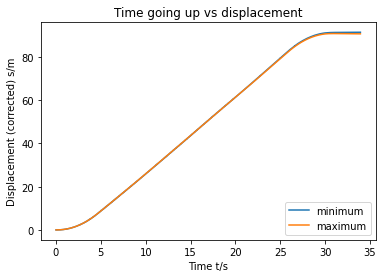

In [15]:
fig, ax = plt.subplots()
ax.set_title("Time going up vs displacement")
ax.set_xlabel("Time t/s")
ax.set_ylabel("Displacement (corrected) s/m")
ax.plot(up_time, up_displacement_z_under, label="minimum")
ax.plot(up_time, up_displacement_z_over, label="maximum")
ax.legend(loc="lower right");

The total displacement is:

In [16]:
up_displacement_z_under[-1]

91.39997794858328

When going down:

In [17]:
down_displacement_z_cumulative_under = 0
down_displacement_z_cumulative_over = 0
down_displacement_z_under = []
down_displacement_z_over = []

# Add one zero to pad the length of the displacement array
down_displacement_z_over.append(0)

for n, down_velocity_here in enumerate(down_velocity_z_under):
    if n + 1 != len(down_velocity_z_under): # Under
        # No value for over-integration if this one is the last one
        under_timediff = down_time[n+1] - down_time[n]
        down_displacement_z_cumulative_under += under_timediff * down_velocity_here
        down_displacement_z_under.append(down_displacement_z_cumulative_under)
        
for n, down_velocity_here in enumerate(down_velocity_z_over):
    if n != 0: # Over
        # No value for under-integration if this one is the last one
        over_timediff = down_time[n] - down_time[n-1]
        down_displacement_z_cumulative_over += over_timediff * down_velocity_here
        down_displacement_z_over.append(down_displacement_z_cumulative_over)
down_displacement_z_under.append(down_displacement_z_cumulative_under)

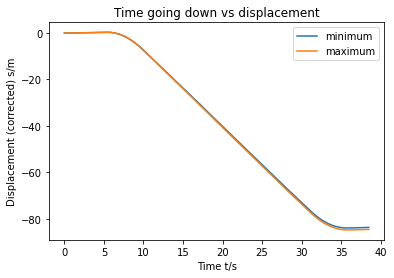

In [18]:
fig, ax = plt.subplots()
ax.set_title("Time going down vs displacement")
ax.set_xlabel("Time t/s")
ax.set_ylabel("Displacement (corrected) s/m")
ax.plot(down_time, down_displacement_z_under, label="minimum")
ax.plot(down_time, down_displacement_z_over, label="maximum")
ax.legend();

The total displacement is:

In [19]:
down_displacement_z_under[-1]

-83.65719579990504

Taking the average of the two, the space travelled is:

In [20]:
height = numpy.mean([-down_displacement_z_under[-1], up_displacement_z_under[-1]])
diff_height = down_displacement_z_under[-1] + up_displacement_z_under[-1]
print(f"{height} ± {diff_height/2} m")

87.52858687424416 ± 3.8713910743391224 m


Taking $3m$ as the floor-floor height of the builing, the number of floors is:

In [21]:
print(f"{int(height/3)} ± 2 floors")

29 ± 2 floors
